# 1_Filtros: Introducción

...inreoduccion

Como primer paso dentro del filtrado de señales de ECG utilicé como modelo el script de http://nbviewer.jupyter.org/github/marianux/jupytest/blob/master/Filtrado%20digital.%20Aplicaciones%20electrocardiograf%C3%ADa.ipynb pero con señales del mit

Los filtros que se desarrollan son pasa banda 3 IIR y un FIR

El filtro de Butterworth es...
El filtro de Chebysher es...
El filtro de Cauer o eliptico es..
El filtro de ventana es...


....

En este bloque se importan las librerías y se abre la señal

In [14]:
import warnings
warnings.filterwarnings('ignore')

import wfdb
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,12)
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as sig
from pandas import DataFrame
from IPython.display import HTML


signals, fields = wfdb.io.rdsamp('101', pb_dir='mitdb')

ecg_one_lead = signals[:,0]

n = np.len(ecg_one_lead)
fs = fields.get('fs')
nyq_frec = fs / 2

AttributeError: module 'numpy' has no attribute 'len'

Primero se realiza la elección de los parametros de atenuacion [Hz], ripple [Hz], frecuencias de paso [Hz] y frecuencias de eliminación [Hz].Luego mediante la funciones iirdesign se diseñan 3 filtros FIR de distintas estructuras (Butterworth, Chebysher y Cauer) y mediante la función firwin2 se diseña otro filtro por el metodo de ventana (para lo cual es necesario definir tambien la cantidad de coeficientes a utilizar). Para ello es necesario expresar las gananncias en veces y normalizar las frecuencias. 
La primera función devuelve los parametros del filtro segun el formato que yo elija (ba, zpk, sos), en este caso en secciones de segundo orden.
Para calcular las respuestas en frecuencia del los filtros digitales diseñados se utilizan las funciones sosfreqz y freqz 

In [15]:
ripple = 0.5
atenuacion = 40.

ws1 = 1.0           
wp1 = 4.0           
wp2 = 15.0          
ws2 = 35.0          

frecs = np.array( [0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ] ) / nyq_frec
gains = np.array( [-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion] )
gains = 10**(gains/20)

bp_sos_butter = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=ripple, gstop=atenuacion, analog=False, ftype='butter', output='sos')
bp_sos_cheby  = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=ripple, gstop=atenuacion, analog=False, ftype='cheby1', output='sos')
bp_sos_cauer  = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=ripple, gstop=atenuacion, analog=False, ftype='ellip' , output='sos')
bp_sos_cheby2 = sig.iirdesign(wp=np.array([wp1, wp2]) / nyq_frec, ws=np.array([ws1, ws2]) / nyq_frec, gpass=ripple, gstop=atenuacion, analog=False, ftype='cheby2', output='sos')

cant_coef = 501
den = 1.0
num_win =   sig.firwin2(cant_coef, frecs, gains , window='blackmanharris' )

w, h_butter = sig.sosfreqz(bp_sos_butter)
_, h_cheby = sig.sosfreqz(bp_sos_cheby)
_, h_cauer = sig.sosfreqz(bp_sos_cauer)
_, h_cheby2 = sig.sosfreqz(bp_sos_cheby2)
_, hh_win = sig.freqz(num_win, den)

Para un primer análisis se imprimen las resuestas en frecuencia de los filtros y la plantilla original

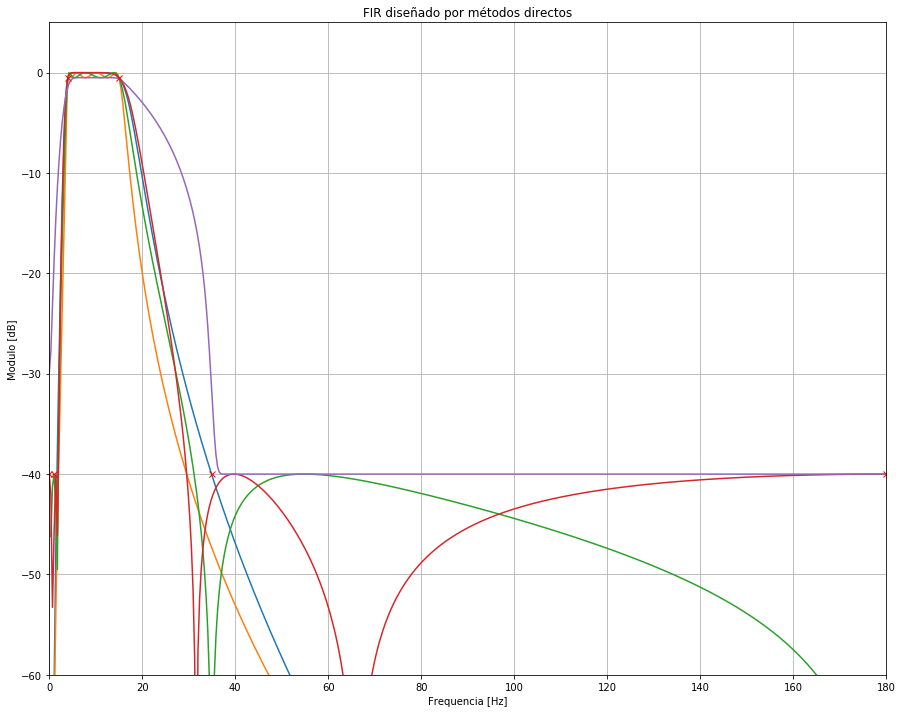

In [16]:
w = w / np.pi * nyq_frec

plt.figure(1)
plt.plot(w, 20*np.log10(np.abs(h_butter)),  label='IIR-Butter' )
plt.plot(w, 20*np.log10(np.abs(h_cheby)),   label='IIR-Cheby' )
plt.plot(w, 20*np.log10(np.abs(h_cauer)),   label='IIR-Cauer' )
plt.plot(w, 20*np.log10(np.abs(h_cheby2)),  label='IIR-Cheby2' )
plt.plot(w, 20 * np.log10(abs(hh_win)),     label='FIR-Win')
plt.plot(frecs * nyq_frec, 20*np.log10(gains), 'rx', label='plantilla' )

plt.title('FIR diseñado por métodos directos')
plt.xlabel('Frequencia [Hz]')
plt.ylabel('Modulo [dB]')
plt.axis([0, nyq_frec, -60, 5 ])

plt.grid()

plt.show()


#This function applies a linear digital filter twice

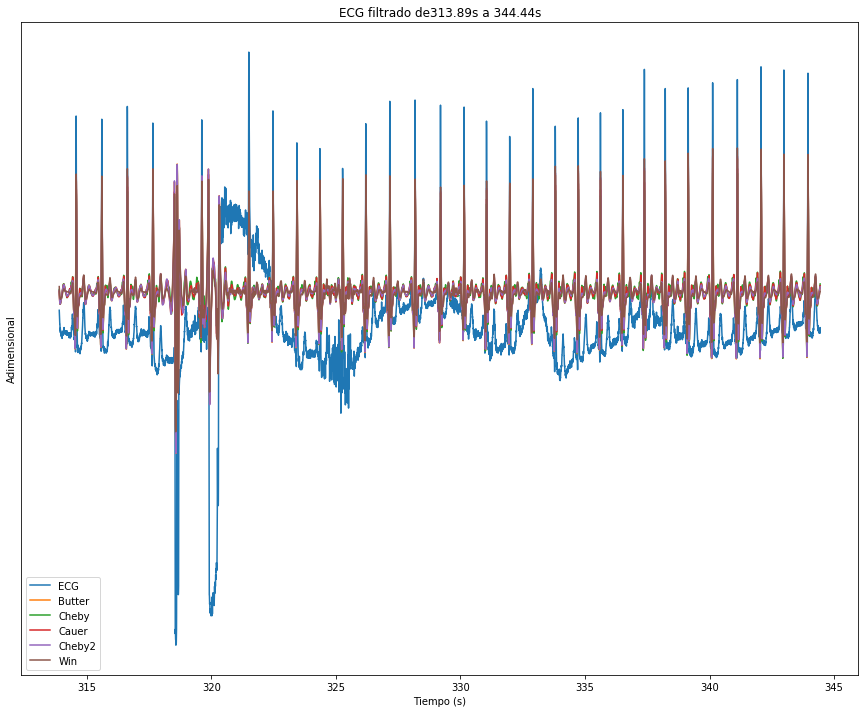

In [30]:
#------Ploteado de los ECG filtrados-------
ECG_f_butt   = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
ECG_f_cheb   = sig.sosfiltfilt(bp_sos_cheby,  ecg_one_lead)
ECG_f_cauer  = sig.sosfiltfilt(bp_sos_cauer,  ecg_one_lead)
ECG_f_cheby2 = sig.sosfiltfilt(bp_sos_cheby2, ecg_one_lead)
ECG_f_win    = sig.filtfilt(num_win, den, ecg_one_lead)


zoom_region = np.arange( 113000, 124000, dtype='uint')

plt.figure(2)
plt.plot( zoom_region/fs, ecg_one_lead[zoom_region],   label='ECG'   )
plt.plot( zoom_region/fs,  ECG_f_butt[zoom_region],     label='Butter')
plt.plot( zoom_region/fs,  ECG_f_cheb[zoom_region],     label='Cheby' )
plt.plot( zoom_region/fs,  ECG_f_cauer[zoom_region],    label='Cauer' )
plt.plot( zoom_region/fs,  ECG_f_cheby2[zoom_region],   label='Cheby2')
plt.plot( zoom_region/fs,  ECG_f_win[zoom_region],      label='Win'   )

plt.title('ECG filtrado de' + str(round((113000/fs),2)) + 's a ' + str(round((124000/fs),2)) + 's' )
plt.ylabel('Adimensional')
plt.xlabel('Tiempo (s)')

axes_hdl = plt.gca()
axes_hdl.legend()
axes_hdl.set_yticks(())

plt.show()

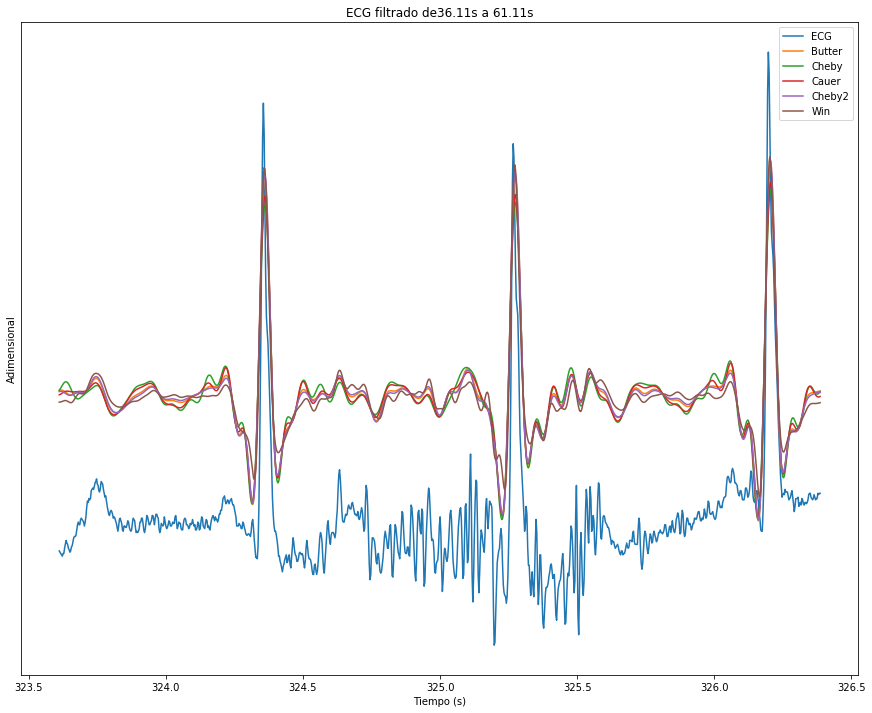

In [38]:
#------Ploteado de los ECG filtrados-------
ECG_f_butt   = sig.sosfiltfilt(bp_sos_butter, ecg_one_lead)
ECG_f_cheb   = sig.sosfiltfilt(bp_sos_cheby,  ecg_one_lead)
ECG_f_cauer  = sig.sosfiltfilt(bp_sos_cauer,  ecg_one_lead)
ECG_f_cheby2 = sig.sosfiltfilt(bp_sos_cheby2, ecg_one_lead)
ECG_f_win    = sig.filtfilt(num_win, den, ecg_one_lead)


zoom_region = np.arange( 116500, 117500, dtype='uint')

plt.figure(2)
plt.plot( zoom_region/fs, ecg_one_lead[zoom_region],   label='ECG'   )
plt.plot( zoom_region/fs,  ECG_f_butt[zoom_region],     label='Butter')
plt.plot( zoom_region/fs,  ECG_f_cheb[zoom_region],     label='Cheby' )
plt.plot( zoom_region/fs,  ECG_f_cauer[zoom_region],    label='Cauer' )
plt.plot( zoom_region/fs,  ECG_f_cheby2[zoom_region],   label='Cheby2')
plt.plot( zoom_region/fs,  ECG_f_win[zoom_region],      label='Win'   )

plt.title('ECG filtrado de' + str(round((13000/fs),2)) + 's a ' + str(round((22000/fs),2)) + 's' )
plt.ylabel('Adimensional')
plt.xlabel('Tiempo (s)')

axes_hdl = plt.gca()
axes_hdl.legend()
axes_hdl.set_yticks(())

plt.show()

Luego de la ver como se modifica la señal procedemos a ver como se modifica el espectro

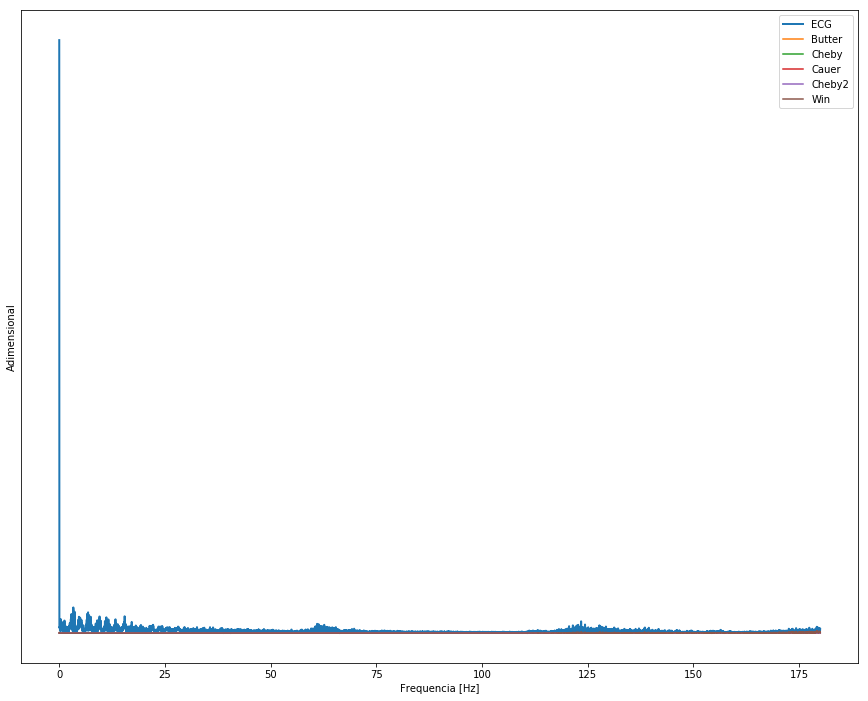

In [39]:
#------CALCULO DE LA FFT -------
resf = fs/n                                 
rangof = np.arange( 0, 360 , resf)         

FFT_ecg_one_lead = np.fft.fft( ecg_one_lead )
FFT_ECG_f_butt = np.fft.fft( ECG_f_butt )  
FFT_ECG_f_cheb = np.fft.fft( ECG_f_cheb )  
FFT_ECG_f_cauer = np.fft.fft( ECG_f_cauer )   
FFT_ECG_f_cheby2 = np.fft.fft( ECG_f_cheby2 )  
FFT_ECG_f_win = np.fft.fft( ECG_f_win )              

rangof = rangof[range(n//2)]     

FFT_ecg_one_lead = abs(FFT_ecg_one_lead[range(n//2)] ) / (n//2)    
FFT_ECG_f_butt   = abs(FFT_ECG_f_butt[range(n//2)]   ) / (n//2)  
FFT_ECG_f_cheb   = abs(FFT_ECG_f_cheb[range(n//2)]   ) / (n//2)  
FFT_ECG_f_cauer  = abs(FFT_ECG_f_cauer[range(n//2)]  ) / (n//2)  
FFT_ECG_f_cheby2 = abs(FFT_ECG_f_cheby2[range(n//2)]  ) / (n//2)  
FFT_ECG_f_win    = abs(FFT_ECG_f_win[range(n//2)]    ) / (n//2)  

plt.figure(3)
plt.plot( rangof, FFT_ecg_one_lead,   label='ECG', lw=2)
plt.plot( rangof, FFT_ECG_f_butt,     label='Butter')
plt.plot( rangof, FFT_ECG_f_cheb,     label='Cheby')
plt.plot( rangof, FFT_ECG_f_cauer,    label='Cauer')
plt.plot( rangof, FFT_ECG_f_cheby2,   label='Cheby2')
plt.plot( rangof, FFT_ECG_f_win,      label='Win')

ii = [0,n]
plt.ylabel('Adimensional')
plt.xlabel('Frequencia [Hz]')

axes_hdl = plt.gca()
axes_hdl.legend()
axes_hdl.set_yticks(())


plt.show()